# Learning consumption rules

This exercise is inspired from *Individual learning about consumption*
by Todd Allen and Chris Carroll
[link](https://www.econstor.eu/bitstream/10419/72016/1/328292125.pdf)
and from *Deep Learning for Solving Economic models* by Maliar, Maliar
and Winant [link](https://web.stanford.edu/~maliars/Files/JME2021.pdf)

We consider the following consumption saving problem. An agent receives
random income $y_t = \exp(\epsilon_t)$ where
$\epsilon_t\sim \mathcal{N}(\sigma)$ ($\sigma$ is the standard
deviation.)

Consumer starts the period with available income $w_t$. The law of
motion for available income is:

$$w_t = \exp(\epsilon_t) + (w_{t-1}-c_{t-1}) r$$

where consumption $c_t \in ]0,w_t]$ is chosen in each period in order to
maximize:

$$E_t \sum_{t=0}^T \beta^t U(c_t)$$

given initial available income $w_0$.

In the questions below, we will use the following calibration:

-   $\beta = 0.9$
-   $\sigma = 0.1$
-   $T=100$
-   $U(x) = \frac{x^{1-\gamma}}{1-\gamma}$ with $\gamma=2$
-   $w_0 = 1.1$ (alternatively, consider values 0.5 and 1)

The theoretical solution to this problem is a concave function $\varphi$
such that $\varphi(x)\in ]0,x]$ and $\forall t,  c_t=\varphi(w_t)$.
Qualitatively, agents accumulate savings, up to a certain point (a
buffer stock), beyond which wealth is not increasing any more (in
expectation).

Carroll and Allen have noticed that the true solution can be
approximated very well by a simple rule:

$$\psi(x) = \min(x, \theta_0 + \theta_1 (x - \theta_0) )$$

The main question they ask in the aforementioned paper is whether it is
realistic that agents would learn good values of $\theta_0$ and
$\theta_1$ by observing past experiences.

We would like to examine this result by learning the optimal rule using
stochastic gradient descent.

In the whole notebook, we use JAX to perform the calculations.

In [83]:
from jax import numpy as jnp
from jax import random

<span class="theorem-title">**Exercise 1**</span> Define a class to
represent the parameter values

In [84]:
from dataclasses import dataclass

In [175]:
@dataclass
class Model:
    β=0.96
    σ=0.1
    γ=4.0
    r=1.05
    T=100
    # def U(self, x):
    #     return 

<span class="theorem-title">**Exercise 2**</span> Define simple rule
fonction `consumption(w: float, θ_0:float, θ_1:float, p:Model)->float`
which compute consumption using a simple rule. What is the meaning of
$\theta_0$ and $\theta_1$? Make a plot in the space $w,c$, including
consumption rule and the line where $w_{t+1} = w_t$. Check that it works
when `w` is a JAX vector.

In [176]:
def consumption(w, a, b, p):
    return jnp.minimum(w, a + b*(w-a) )

In [177]:
m = Model()

In [320]:
p = dict(β=0.9,σ=0.1,γ=2.0,r=1.04)

In [321]:
consumption(2.0, 0.9, 0.1, m)

Array(1.01, dtype=float32, weak_type=True)

In [258]:
wvec = jnp.linspace(0,2,100)
θ_0 = 1.0
θ_1 = 0.05
cvec = consumption(wvec, θ_0, θ_1, m)


Text(0, 0.5, '$c_t$')

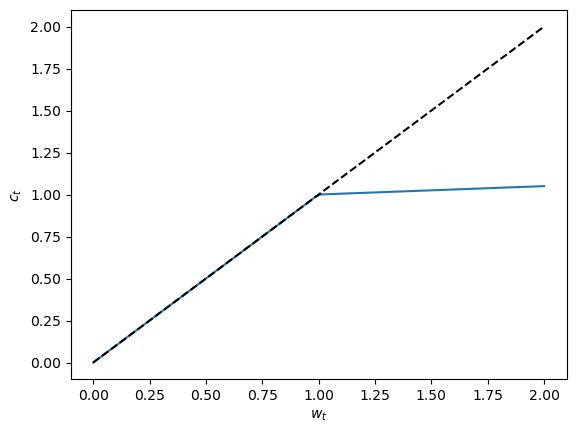

In [259]:
from matplotlib import pyplot as plt
plt.plot(wvec, cvec)
plt.plot(wvec, wvec, color='black', linestyle='--')
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")

<span class="theorem-title">**Exercise 3**</span> Write a function
`lifetime_reward(w_0: float, θ_0: float, θ_1: float, p:Model, key, T)->float`
which computes one realization of $\sum_{t=0}^T \beta^t U(c_t)$ for
initial wealth `w_0` and simple rule `θ_0`, `θ_1` and random key `key`.
Mathematically, we denote it by $\xi(\omega; \theta_0, \theta_1)$, where
$\omega$ represents the succession of random income draws. Check the
result is unchanged, when the result is computed from the same original
key.

Can you JIT compile the resulting fonction? What is the gain of using a
native JAX loop?

(hint: to use native loop, T needs to be treated as a constant paramete
)

In [260]:
p

{'β': 0.9, 'σ': 0.1, 'γ': 2.0, 'r': 1.04}

In [261]:
def lifetime_reward_unrolled(w_0, θ_0, θ_1, p, key, T=100):
    V = 0.0
    w = w_0

    γ = p['γ']
    β = p['β']
    σ = p['σ']
    r = p['r']
    
    for t in range(T):
        c = consumption(w, θ_0, θ_1, p)
        U = c**(1-γ)/(1-γ)
        V += β**t*U
        y = jnp.exp(
            random.normal(key)*σ
        )
        w = y + (w-c)*r
        subkey, _ = random.split(key)

    return V

In [214]:
key0 = random.key(1)
lifetime_reward_unrolled(1.0, 0.6, 0.04, p, key0, T=100)

Array(-29.078854, dtype=float32)

In [263]:
from jax import jit
lru = jit(lifetime_reward_unrolled, static_argnames=['T'])

In [264]:
lru(2.0, 0.6, 0.05, p, key0, T=1000)

Array(-13.020387, dtype=float32)

In [265]:
%timeit lifetime_reward_unrolled(2.0, 1.0, 0.05, p, key0, T=1000)

112 ms ± 663 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [266]:
%timeit lru(2.0, 1.0, 0.05, p, key0, T=1000)

24.3 μs ± 1.54 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [267]:
lru(2.0, 1.0, 0.05, p, key0, T=1000)

Array(-10.286169, dtype=float32)

In [268]:
lru(2.0, 1.09, 0.05, p, key0, T=1000)

Array(-10.264093, dtype=float32)

In [269]:
from jax import lax

def lifetime_reward(w_0, θ_0, θ_1, p, key, T=1000):
    V = 0.0
    w = w_0

    γ = p['γ']
    β = p['β']
    σ = p['σ']
    r = p['r']

    def loop_body(t, arg):
        w, V = arg
        c = consumption(w, θ_0, θ_1, p)
        U = c**(1-γ)/(1-γ)
        V1 = V + β**t*U
        y = jnp.exp(random.normal(key)*σ)
        w1 = y + (w-c)*r
        subkey, _ = random.split(key)
        return (w1, V1)
        
    w_, V_ = lax.fori_loop(0, T, loop_body, (w_0, 0.0))
    return V_
        

In [270]:
lifetime_reward(2.0, 0.5, 0.05, p, key0, T=100)

Array(-14.243424, dtype=float32, weak_type=True)

In [271]:
lifetime_reward(2.0, 1.01, 0.04, p, key0, T=100)

Array(-10.285437, dtype=float32, weak_type=True)

In [272]:
lr = jit(lifetime_reward, static_argnames=['T'])

In [273]:
%timeit lifetime_reward(2.0, 1.0, 0.05, p, key0, T=100)

73.3 ms ± 5.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [274]:
%timeit lr(2.0, 1.0, 0.05, p, key0, T=100)

15.3 μs ± 1.41 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


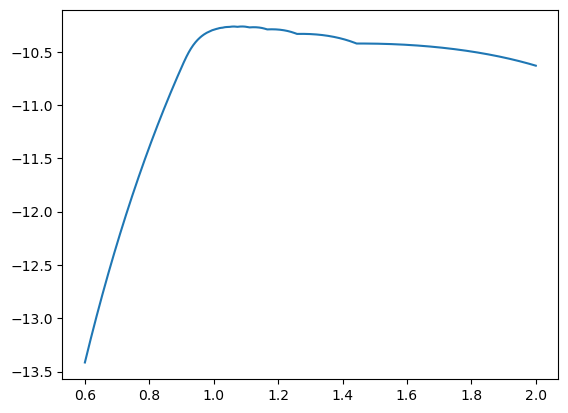

In [275]:
vec = jnp.linspace(0.6, 2.0, 1000)
yvec = [lr(2.0, h, 0.04, p, key0, T=100) for h in vec]
plt.plot(vec, yvec)

<span class="theorem-title">**Exercise 4**</span> Write a function
`lifetime_reward(w_0: float, θ_0: float, θ_1: float, p:Model, key, N, T)->float`
which computes expected lifetime reward using `N` Monte-Carlo draws.
Mathematically, we write it
$\Xi^{N}(\theta_0, \theta_1) =\frac{1}{N} \sum_1^N {\xi(\omega_N; \theta_0, \theta_1)}$.
Check empirically that standard deviation of these draws decrease
proportionally to $\frac{1}{\sqrt{N}}$ .

In [276]:
import jax
def expected_lifetime_reward(w_0, θ_0, θ_1, p, key, T=100, N=100):
    vlr = jax.vmap(
        lambda w, key: lr(w, θ_0, θ_1, p, key, T=T),
    )
    wvec = jnp.repeat(w_0, N)
    keys = random.split(key, N)
    return vlr(wvec, keys).mean()

In [277]:
%time expected_lifetime_reward(2.0,0.6, 0.05, p, key0, T=100)

CPU times: user 154 ms, sys: 1.98 ms, total: 156 ms
Wall time: 150 ms


Array(-12.453702, dtype=float32)

In [278]:
elr = jit(expected_lifetime_reward)
elr(2.0, 1.0, 0.05, p, key0, T=100);

/home/pablo/.local/opt/micromamba/envs/bbank/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/pablo/.local/opt/micromamba/envs/bbank/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


In [279]:
%time elr(2.0, 1.0, 0.05, p, key0, T=100)

CPU times: user 575 μs, sys: 9 μs, total: 584 μs
Wall time: 360 μs


Array(-9.638419, dtype=float32)

In [280]:
elr(2.0, 0.6, 0.05, p, key0, T=100)

Array(-12.453702, dtype=float32)

/home/pablo/.local/opt/micromamba/envs/bbank/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/pablo/.local/opt/micromamba/envs/bbank/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


(-10.0, -5.0)

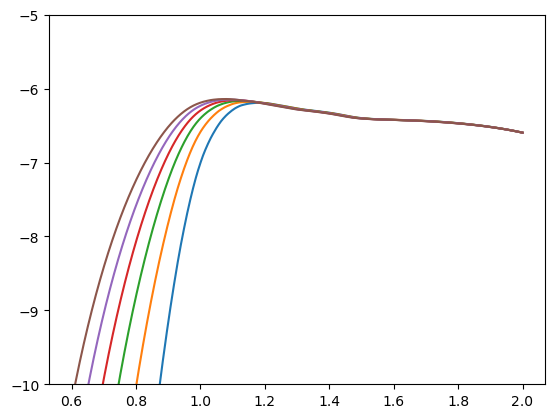

In [281]:
p = dict(β=0.95,σ=0.1,γ=4.0,r=1.04)
vec = jnp.linspace(0.6, 2.0, 1000)
yvecs = [
    [elr(2.0, h, i, p, key0, T=1000) for h in vec]
    for i in [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
]
for yvec in yvecs:
    plt.plot(vec, yvec)
plt.ylim(-10, -5)

<span class="theorem-title">**Exercise 5**</span> Using a high enough
number for `N`, compute optimal values for $\theta_0$ and $\theta_1$.
What is the matching value for the objective function converted into an
equivalent stream of deterministic consumption ? That is if `V` is the
approximated value computed above, what is $\bar{c}\in R$ such that
$V= \sum_{t=0}^T \beta^t U(\bar{c})$ ?

In [302]:
K = 100
t0_vec = jnp.linspace(0.5, 1.5,  K)
t1_vec = jnp.linspace(0.0, 0.4, K)

In [303]:

t0_ = t0_vec[:,None].repeat(K,axis=1).ravel()
t1_ = t1_vec[None,:].repeat(K,axis=0).ravel()
# This is a mesh ( the lines of np.column_stack([t0_,t1_])  contain all possible combinations of t0 and t1

# we compute random keys for each point of the mesh


In [336]:
w_0_ = 2.0
N = 100000 # this needs to be rather large for the plot to be smooth
keys = random.split(key0, K*K)
vals = jax.vmap(
    lambda t0, t1, key: expected_lifetime_reward(w_0_, t0, t1, p, key, T=100, N=N)
)(
    t0_, t1_, keys
)

In [337]:
vals = vals.reshape((K,K))

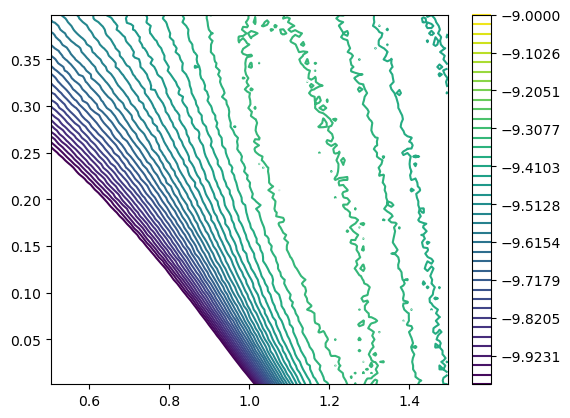

In [344]:
# we can represent the values as a heatap
import matplotlib.pyplot as plt
import numpy as np
plt.contour(
    np.array(vals.T),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    levels=np.linspace(-10, -9, 40),
    
)
plt.colorbar()

In [347]:
# for a more insightful plot, we can convert into consumption equivalents
cvals = vals**(1/(1-p['γ']))*(1-p['γ'])
# let's normalize as % deviation from the maximum
cvals = (cvals/cvals.max()-1)

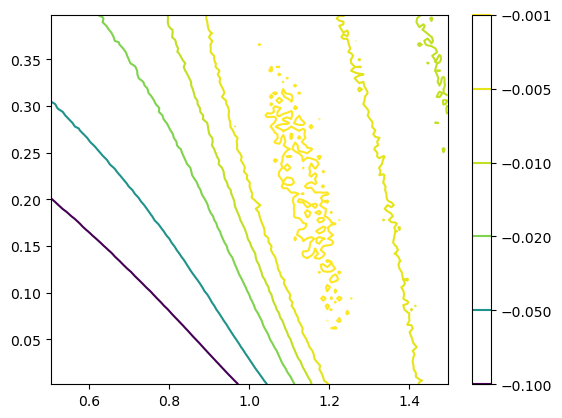

In [350]:
# we can represent the values as a heatap
import matplotlib.pyplot as plt
import numpy as np
plt.contour(
    np.array(cvals.T),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    levels=[-0.1,-0.05, -0.02, -0.01, -0.005, -0.001],
    
)
plt.colorbar()

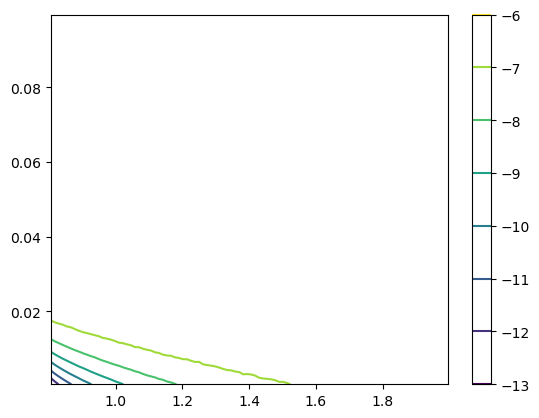

In [287]:
# we can represent the values as a heatap
import matplotlib.pyplot as plt
import numpy as np
plt.contour(
    np.array(vals),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    # levels=[-22.5,-22,-21,-20.5, -20, -19.5]
    # vmin=-50,
    # vmax=50
)
plt.colorbar()

In [142]:
jnp.repeat( t0_[None,:],  N).shape

(1000000,)

In [144]:
random.split(key0, (N,K*K)).shape

(100, 10000)

In [154]:
 # we now want to make N*K*K evaluations of t
N = 100
vfun = jax.vmap(
    jax.vmap(
        lambda w, t0, t1, key: lr(w, t0, t1, p, key, T=100),
        0
    ),
    0
)
vals = vfun(
    jnp.ones((N,K*K))*w_0,
    jnp.repeat( t0_[None,:],  N, axis=0),
    jnp.repeat( t1_[None,:],  N, axis=0),
    random.split(key0, (N,K*K))
)
    
# w_0_ = 1.0
#     wvec = jnp.repeat(w_0, N)

#     vec_call = jax.vmap(
#         lambda w, t0, t1, key: lr(w, t0, t1, p, key, T=T),
#     )


In [156]:
vals = vals.mean(axis=0)

In [157]:
vals = vals_.reshape((K,K))

In [158]:
vals[0,:]

Array([-10.1272545, -10.215731 ,  -9.918333 , -10.052396 , -10.045228 ,
       -10.020708 , -10.016466 , -10.119742 , -10.099981 , -10.103628 ,
       -10.226678 , -10.053953 , -10.041744 ,  -9.998288 , -10.139137 ,
        -9.950501 , -10.032368 , -10.198214 , -10.176594 , -10.05619  ,
       -10.026363 , -10.100059 , -10.008214 , -10.0258665, -10.102597 ,
        -9.898235 , -10.003592 , -10.005539 , -10.132068 , -10.003181 ,
        -9.986605 ,  -9.982905 , -10.041628 , -10.033707 , -10.036638 ,
        -9.915226 , -10.029209 ,  -9.902589 , -10.081055 , -10.067438 ,
       -10.101193 , -10.096603 , -10.203031 , -10.046    , -10.093906 ,
        -9.98284  , -10.050775 , -10.068933 , -10.141783 , -10.10365  ,
       -10.0072775,  -9.948462 , -10.037669 , -10.009825 , -10.152557 ,
       -10.097465 ,  -9.921829 ,  -9.923711 ,  -9.9416065, -10.063315 ,
        -9.970956 ,  -9.991988 ,  -9.997067 , -10.121689 , -10.0069   ,
       -10.076339 , -10.066641 , -10.121218 , -10.174465 , -10.0

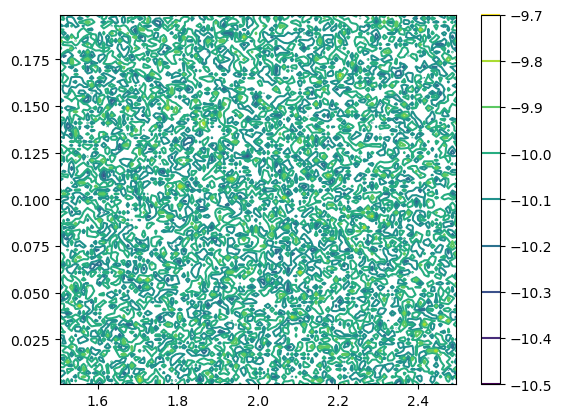

In [159]:
# we can represent the values as a heatap
import matplotlib.pyplot as plt
import numpy as np
plt.contour(
    np.array(vals),
    origin='lower',
    extent=(t0_vec.min(), t0_vec.max(), t1_vec.min(), t1_vec.max()),
    # levels=[-22.5,-22,-21,-20.5, -20, -19.5]
    # vmin=-50,
    # vmax=50
)
plt.colorbar()

In [83]:
vals.max()

Array(-10.036847, dtype=float32)

In [84]:
vals.max()

Array(-10.036847, dtype=float32)

AttributeError: Line3DCollection.set() got an unexpected keyword argument 'axlim_clip'

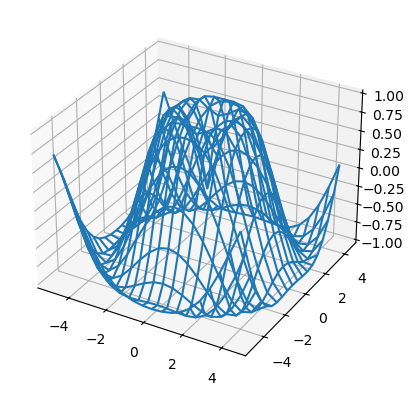

In [37]:
# we can try a 3d plot

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make the data
x = np.arange(-5, 5, 0.5)
y = np.arange(-5, 5, 0.5)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Default behavior is axlim_clip=False
ax.plot_wireframe(X, Y, Z, color='C0')

# When axlim_clip=True, note that when a line segment has one vertex outside
# the view limits, the entire line is hidden. The same is true for 3D patches
# if one of their vertices is outside the limits (not shown).
ax.plot_wireframe(X, Y, Z, color='C1', axlim_clip=True)

# In this example, data where x < 0 or z > 0.5 is clipped
ax.set(xlim=(0, 10), ylim=(-5, 5), zlim=(-1, 0.5))
ax.legend(['axlim_clip=False (default)', 'axlim_clip=True'])

plt.show()

<span class="theorem-title">**Exercise 6**</span> Using a high enough
number for `N`, make contour plots of lifetime rewards as a function of
`θ_0` and `θ_1`. Ideally, represent lines with $1\%$ consumption loss,
$5\%$ and $10\%$ deterministic consumption loss w.r.t. to maximum.

In [ ]:
# your code here

## Learning to save

We now focus on the number of steps it takes to optimize $\theta_0$,
$\theta_1$.\_\_

<span class="theorem-title">**Exercise 7**</span> Implement a function
`∇(θ:Vector, T, N)::Vector` which computes the gradient of the objective
w.r.t. `θ==[θ_0,θ_1]`\_\_

In [ ]:
# your code here

<span class="theorem-title">**Exercise 8**</span> Implement a gradient
descent algorithm to maximize $\Xi^N(\theta_0, \theta_1)$ using learning
rate $\lambda \in ]0,1]$. Stop after a predefined number of iterations.
Compare convergence speed for different values of $\lambda$ and plot
them on the $\theta_0, \theta_1$ plan. How many steps does it take to
enter the `1%` error zone? The `5%` and the `10%` error zone?

In [ ]:
# your code here

Even for big N, the evaluated value of ∇ are stochastic, and always
slightly inaccurate. In average, they are non-biased and the algorithm
converges in expectation (it fluctuates around the maximum). This is
called the stochastic gradient method.

<span class="theorem-title">**Exercise 9**</span> What are the values of
$N$ and $\lambda$ which minimize the number of iterations before
reaching the target zones (at 1%, 2%, etc…)? How many simulations
periods does it correspond to? Would you say it is realistic that
consumers learn from their own experience?

In [10]:
# your code here